# Initialisation

**First : change the runtime and hardware acceleration**

Runtime $\rightarrow$ Change runtime type

- Runtime type : Python 3
- Hardware accelerator : GPU

In [1]:
# Install TensorFlow 2.0 on Google Collab if needed
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [29]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt  

In [2]:
#Set the GPU you want to use
num_GPU = 0

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

if num_GPU < len(gpus):
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
    print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.0.0
Number of GPUs available : 4
Only GPU number 0 used


# Tensorflow for beginners

![Keras](https://github.com/mgoutay/ml_course/blob/master/Images/Keras.png?raw=true)

Imports pre-made Keras Layers

In [94]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Softmax

## Dataset

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). 

It consists in B&W handwritten digits (matrices of size 28x28) and their corresponding labels

In [172]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

See what's inside the dataset, here with the three first digits and their corresponding labels :

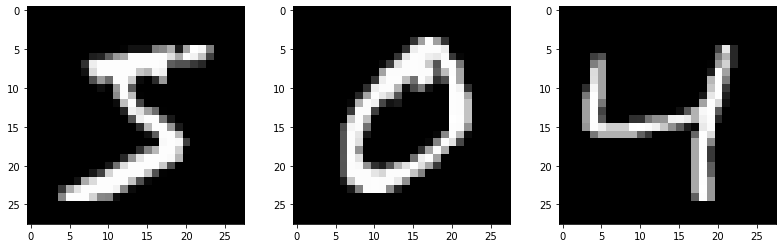

Corresponding labels: 5, 0, 4


In [48]:
fig = plt.figure(figsize=(3*4.5, 4))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
plt.show()
print('Corresponding labels: '+ str(y_train[0])+ ', '+str(y_train[1])+ ', '+ str(y_train[2]))

## Building the model

Build the `tf.keras.Sequential` model by stacking layers. 

In [142]:
model = tf.keras.models.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(64, activation='relu'),
    Dense(10),
    Softmax(),
])

The output is a vector of probabilities.
Let's create a batch with the 3 first example in the dtaset and predcit their probabilities :

In [143]:
batch = x_train[:3]
probas = model(batch)
print(probas)

tf.Tensor(
[[0.04920179 0.10518356 0.05880045 0.09953135 0.19725585 0.14027986
  0.12093253 0.04928183 0.10673869 0.07279396]
 [0.04801886 0.10444789 0.09942514 0.07844663 0.22323747 0.0851827
  0.09963126 0.10439971 0.06858873 0.08862156]
 [0.08915557 0.14513278 0.0619632  0.05977226 0.17422573 0.07686426
  0.12923633 0.07960777 0.08103887 0.10300319]], shape=(3, 10), dtype=float32)


We can take the $\text{argmax}$ of each vector to see the digit with the highest predicted probability:

In [144]:
predictions = tf.argmax(probas, axis=1)
print(predictions)

tf.Tensor([4 4 4], shape=(3,), dtype=int64)


The model is not trained and the predictions are totally wrong.

**So how do we train it?**

First, we need a loss function : for a classification task, it is the *categorical cross-entropy* :

In [145]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

Test the untrained network on the 3 first examples of the dataset:

In [146]:
loss_fn(y_train[:3], probas)

<tf.Tensor: id=2301687, shape=(), dtype=float32, numpy=2.2492268>

The loss is BIG. That's normal, the NN is not trained.

So, let's train the model !

## Training

Define :

- An optimizer (Adam)
- A loss function (loss_fn)
- A metric (the NN Accuracy)

In [147]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

The `Model.fit` method adjusts the model parameters to minimize the loss: 

In [148]:
model.fit(x_train, y_train, batch_size=128, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 35us/sample - loss: 0.4210 - accuracy: 0.8863
Epoch 2/5
60000/60000 [==============================] - 2s 30us/sample - loss: 0.2024 - accuracy: 0.9433
Epoch 3/5
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1554 - accuracy: 0.9550
Epoch 4/5
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1248 - accuracy: 0.9640
Epoch 5/5
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1056 - accuracy: 0.9696


The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)".

In [149]:
model.evaluate(x_test,  y_test, verbose=2)

10000/1 - 1s - loss: 0.0635 - accuracy: 0.9654


[0.1156543973121792, 0.9654]

The model is now trained an the loss is very small!

Also look at the accuracy : after a small training, we reach ~98% of good predictions

We can now re-test the model on the first 3 examples of the batch:

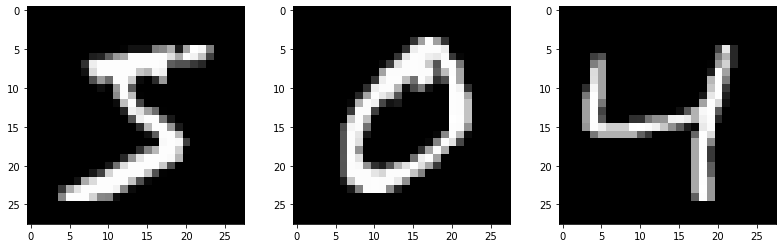

Predictions : 
tf.Tensor([5 0 4], shape=(3,), dtype=int64)


In [150]:
fig = plt.figure(figsize=(3*4.5, 4))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
plt.show()
print('Predictions : ')

predictions = model(x_train[:3])
print(tf.argmax(predictions, axis=1))

That's good!

# Tensorflow for experts

## Automatic differentiation

The `tf.GradientTape API` provides automatic differentiation.

All operations executed inside a gradient tape are recorded:

Let's say that we have a feature $x = 3$

The NN implements $y=x^2$

We can find the derivative of $y$ w.r.t. $x$ : $\frac{dy}{dx} = 2x = 6$

In [151]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape :
    y = tf.square(x)
dy_dx = tape.gradient(y,x)
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


# Datasets

Datasets are a cleaner way to manipulate large amount of date

Use `tf.data` to batch and shuffle the dataset:



In [157]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(128)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## Custom Keras model

Build a `tf.keras` Model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing):

In [158]:
from tensorflow.keras import Model

A model has at least two methods:

- The `__init__` methods : here you define the model's attributes. All layers that will be used needs to be defined here
- the `call` method : here you write the forward pass of your model

`super` calls the parent's constructor. We won't go into details...

`@tf.function` speeds up the training

In [159]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Define your model's attributes
        self.flat = Flatten(input_shape=(28, 28))
        self.d1 = Dense(64, activation='relu')
        self.d2 = Dense(10)
        self.smax = Softmax()
    
    @tf.function
    def call(self, x):
        #write the forward pass
        x = self.flat(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.smax(x)
        return x

Instantiate a model:

In [169]:
# Create an instance of the model
model = MyModel()

## Training

Choose an optimizer and loss for training:

In [170]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [171]:
#Define the number of epochs
nb_epoch = 5

print('Loss after each epoch:')

for epoch in range(nb_epoch):
    
    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(train_ds):
        
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas = model(features)

            # Loss value for this batch.
            loss_value =  loss_fn(y_true=labels, y_pred=probas)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    #Test the model on the test datasets
    test_loss = 0.
    i=0
    for step, (features, labels) in enumerate(test_ds):
        probas = model(features)
        test_loss += loss_fn(y_true=labels, y_pred=probas)
        i+=1
    print((test_loss/(step+1)).numpy(), end=', ')
print('Done')

Loss after each epoch:
0.22975998, 0.17113169, 0.1445612, 0.12783802, 0.110222645, Done


Let's predict again the first 3 examples of the dataset

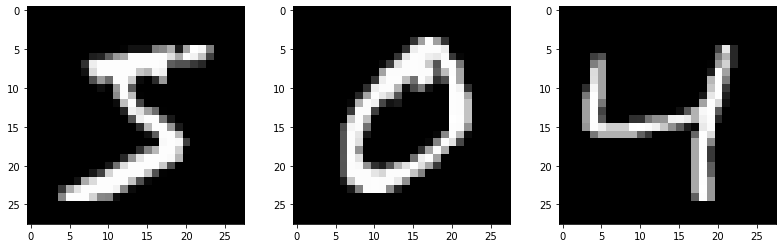

Predictions : 
tf.Tensor([5 0 4], shape=(3,), dtype=int64)


In [164]:
fig = plt.figure(figsize=(3*4.5, 4))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
plt.show()
print('Predictions : ')

predictions = model(x_train[:3])
print(tf.argmax(predictions, axis=1))